In [9]:
import numpy as np 
from matplotlib import pyplot as plt

# Simulateur fiscal

Le SRD est un simulateur fiscal qui peut être téléchargé facilement en utilisant l'outil pip, qui est pré-installé sous python. La documentation de cet outil se trouve sur le site suivant: [https://creei-models.github.io/srd/](https://creei-models.github.io/srd/).  On n'a qu'à lancer cette commande: 


In [10]:
!pip install srd

Defaulting to user installation because normal site-packages is not writeable


On importe le module avec 

In [11]:
import srd

# Contrainte budgétaire

Une des utilisations d'un simulateur fiscal est de tracer des contraintes budgétaires réelles. Le SRD compte plus de 90% des mesures fiscales fédérales et provinciales en plus des transferts d'aide sociale. Ici on regarde le cas d'un individu en 2019 qui gagne seulement 10 000$ en revenu de travail. 

In [12]:
jean = srd.Person(earn=10e3)
case = srd.Hhold(jean)
tax = srd.tax(2019)

On calcule ensuite son revenu disponible


In [13]:
case = tax.compute(case)

In [14]:
case.fam_disp_inc

14608.16

Après avoir calculé son revenu disponible, on voit que celui-ci est plus élevé que son revenu de travail. C'est parce qu'il reçoit divers transferts qui augmentent ses revenus. Maintenant, on regarde une contrainte budgétaire. 


In [15]:
wage = 35.0
hours = np.linspace(0,60,100)

In [16]:
netinc = []
for h in hours: 
  jean = srd.Person(earn=wage*h*52)
  case = srd.Hhold(jean)
  case = tax.compute(case)
  netinc.append(case.fam_disp_inc)


On calcule le loisir


In [17]:
leisure = 5*16 - hours

On peut maintenant tracer la contrainte


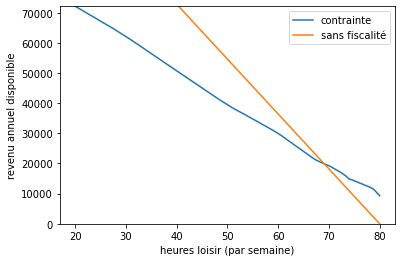

In [18]:
plt.figure()
plt.plot(leisure,netinc,label='contrainte')
plt.plot(leisure,hours*wage*52,label='sans fiscalité')
plt.xlabel('heures loisir (par semaine)')
plt.ylabel('revenu annuel disponible')
plt.ylim([0,max(netinc)])
plt.legend()
plt.show()

On voit que la fiscalité a deux effets pour ce cas-type: elle augmente d'abord le revenus quand la personne ne travaille pas. Ensuite, elle diminue le gain marginal de diminuer le loisir en terme de consommation. Donc, la contrainte pivote sur elle-même. 


# TEMI

On peut calculer le TEMI, le taux effectif marginal d'imposition en utilisant les calculs que nous venons de faire. 

In [19]:
temis = []
for i,h in enumerate(hours[:-1]): 
   x = 1.0 - (netinc[i+1] - netinc[i])/(wage*(hours[i+1]-hours[i])*52) 
   temis.append(x)

On peut tracer le TEMI. On voit que le TEMI est très élevé pour un nombre d'heure de travail faible. 


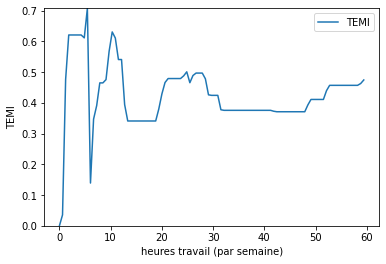

In [20]:
plt.figure()
plt.plot(hours[:-1],temis,label='TEMI')
plt.xlabel('heures travail (par semaine)')
plt.ylabel('TEMI')
plt.ylim([0,max(temis)])
plt.legend()
plt.show()

# Utilité et choix optimal

On peut mettre en application ce que nous avons fait pour le choix optimal. La première étape est de définir la fonction d'utilité

In [21]:
def u(c,h,phi,eps):
  g = 1 + + 1/eps
  return c - phi*(h**g) / g

On fixe ensuite les paramètres


In [22]:
eps = 1
phi = 1e-2

On peut calculer l'utilité pour tous les choix d'heures de travail


In [23]:
us = [u(c,h,phi,eps) for c,h in zip(netinc,hours*52)]

On obtient alors la courbe d'utilité qui est globalement concave mais a certaines convexités. Il faut en effet faire attention en contexte de contrainte budgétaire réelle car celle-ci sont parfois convexe par rapport à l'origine. Quand ceci arrive, il se peut qu'on ait deux optimums locaux (deux points où le TMS est égal à la pente de la contrainte). Dans ces cas, il faut choisir l'optimum global (celui qui donne l'utilité la plus élevée). En optimisation, on fera attention pour utiliser un algorithme qui n'utilise pas d'information sur les dérivées, comme bisection ou une optimisation sur grille. 


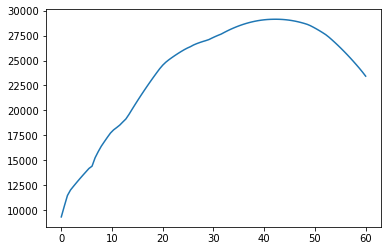

In [24]:
plt.figure()
plt.plot(hours,us)
plt.show()

On obtient donc simplement le choix optimal en prenant le maximum sur notre grille

In [25]:
hopt = hours[np.argmax(us)]

Ce qui donne

In [27]:
hopt

42.42424242424242

# Offre de travail

Maintenant qu'on sait comment faire le choix optimal, on peut tracer la courbe d'offre de travail

In [28]:
def supply(phi,eps,wage,tax):
  hours = np.linspace(0.0,80.0)
  netinc = []
  for h in hours: 
    p = srd.Person(earn=wage*h*52)
    case = srd.Hhold(p)
    case = tax.compute(case)
    netinc.append(case.fam_disp_inc)  
  us = [u(c,h,phi,eps) for c,h in zip(netinc,hours*52)]
  hopt = hours[np.argmax(us)]
  return hopt

In [29]:
wages = np.linspace(13.1,50.0,100)
sc = [supply(1e-2,1.0,w,tax) for w in wages]

On obtient une courbe d'offre avec des sauts, ce qui est en parti dû aux changements brusques de TEMI mais aussi au fait que nous faisons une optimisation sur une grille. La courbe a une pente positive ce qui signifie que l'effet substitution domine l'effet revenu pour ces préférences. 


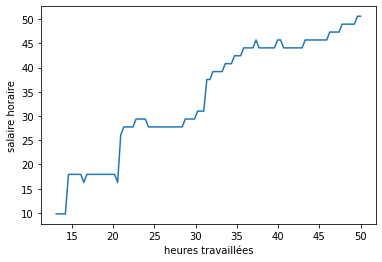

In [30]:
plt.figure()
plt.plot(wages,sc)
plt.xlabel('heures travaillées')
plt.ylabel('salaire horaire')
plt.show()

# Changer de taux d'imposition

On peut changer le taux d'imposition du travailleur pour simuler les effets sur l'offre de travail

In [31]:
tax2 = srd.tax(year=2019)

In [32]:
tax2.federal.l_rates = [t*1.25 for t in tax2.federal.l_rates]

In [33]:
tax2.federal.l_rates

[0.1875, 0.25625, 0.325, 0.3625, 0.41250000000000003]

In [34]:
href = supply(1e-2,1.0,wage,tax)
htax = supply(1e-2,1.0,wage,tax2)

On voit que l'offre de travail diminue d'environ 3 heures par semaines. 

In [35]:
href,htax

(42.44897959183673, 39.183673469387756)

L'élasticité pour ce changement est de -0.3. Ce genre de paramètre est très utile pour déterminer les effets d'un changement d'imposition sur le travail et aussi les revenus d'impôt générés par la hausse. 


In [36]:
eta = (htax/href-1)/0.25

In [37]:
eta

-0.3076923076923075